# Model Evaluation Notebook

This notebook loads the three trained models (Baseline CNN, Fine-tuned GPT-Full, Fine-tuned GPT-Vocab4), evaluates their performance (Pearson R) on a single validation batch, and visualizes the predicted TF-binding scores against the true scores for 5 examples.

## 1. Imports and Setup

In [15]:
import os
import gzip
import random
import pickle
import math
from dataclasses import dataclass

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Configuration
SEQ_PATH   = "tf-binding-prediction/data/chr22_sequences.txt.gz"
SCORE_PATH = "tf-binding-prediction/data/chr22_scores.txt.gz"
META_PATH_FULL = "data/full/meta.pkl"
META_PATH_VOCAB4 = "data/vocab4/meta.pkl"
CKPT_PATH_FULL = "outputs/ckpt_full.pt"
CKPT_PATH_VOCAB4 = "outputs/ckpt_vocab4.pt"
MODEL_PATH_BASELINE = "models/cnn_baseline_model.pt"
MODEL_PATH_FT_FULL = "models/gpt_binding_model_full.pt"
MODEL_PATH_FT_VOCAB4 = "models/gpt_binding_model_vocab4.pt"

BATCH_SIZE = 64 # Can adjust if needed for evaluation
SEED = 42 # For reproducibility of validation split and random sample selection
NUM_VIS_SAMPLES = 5

# Set seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Helper Functions and Model Definitions

In [16]:
# Helper Functions

def one_hot_encode(sequence):
    """Converts a DNA sequence string to a one-hot encoded tensor (4 x SeqLen)."""
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    seq_len = len(sequence)
    encoded = torch.zeros((4, seq_len), dtype=torch.float32)
    for i, base in enumerate(sequence.upper()):
        idx = mapping.get(base, -1) # Use -1 for non-ACGT chars
        if idx != -1:
            encoded[idx, i] = 1.0
    # 'N' or other characters will result in all zeros for that position
    return encoded

def pearson(pred, tgt):
    """Pearson R over flattened predictions/targets."""
    p = pred.detach().cpu().numpy().ravel()
    t = tgt.detach().cpu().numpy().ravel()
    mask = np.isfinite(p) & np.isfinite(t)
    if mask.sum() < 2: return 0.0
    # Use try-except for robustness against zero variance etc.
    try:
        r, _ = pearsonr(p[mask], t[mask])
        return r if np.isfinite(r) else 0.0
    except ValueError:
        return 0.0

# Model Definitions (Copied from training scripts)

@dataclass
class GPTConfig:
    block_size: int = 0; vocab_size: int = 0; n_layer: int = 0
    n_head: int = 0; n_embd: int = 0; dropout: float = 0.0; bias: bool = True

def scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=0.0, is_causal=False, scale=None):
    L,S = q.size(-2), k.size(-2)
    scale_factor = 1/math.sqrt(q.size(-1)) if scale is None else scale
    attn_bias = torch.zeros(L, S, dtype=q.dtype, device=q.device)
    if is_causal:
        mask = torch.tril(torch.ones(L, S, device=q.device))
        mask_inverse = 1.0 - mask
        attn_bias = attn_bias.masked_fill(mask_inverse > 0, float("-inf"))
    if attn_mask is not None:
        attn_bias += attn_mask
    weights = (q @ k.transpose(-2,-1)) * scale_factor + attn_bias
    weights = torch.softmax(weights, dim=-1)
    weights = torch.dropout(weights, dropout_p, train=False) # Ensure dropout is off during eval
    return weights, weights @ v

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias   = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        assert cfg.n_embd % cfg.n_head == 0
        self.c_attn       = nn.Linear(cfg.n_embd, 3*cfg.n_embd, bias=cfg.bias)
        self.c_proj       = nn.Linear(cfg.n_embd, cfg.n_embd, bias=cfg.bias)
        self.attn_dropout = nn.Dropout(cfg.dropout)
        self.resid_dropout= nn.Dropout(cfg.dropout)
        self.n_head       = cfg.n_head
        self.n_embd       = cfg.n_embd
        self.dropout      = cfg.dropout

    def forward(self, x):
        B,T,C = x.size()
        q,k,v = self.c_attn(x).split(self.n_embd, dim=2)
        q = q.view(B,T,self.n_head,C//self.n_head).transpose(1,2)
        k = k.view(B,T,self.n_head,C//self.n_head).transpose(1,2)
        v = v.view(B,T,self.n_head,C//self.n_head).transpose(1,2)
        # Use train=False for dropout during evaluation
        attn_w, out = scaled_dot_product_attention(q,k,v, is_causal=True, dropout_p=self.dropout if self.training else 0.0)
        out = out.transpose(1,2).contiguous().view(B,T,C)
        # Use train=False for dropout during evaluation
        out = self.resid_dropout(self.c_proj(out))
        return out, torch.mean(attn_w, dim=0)

class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.c_fc    = nn.Linear(cfg.n_embd, 4*cfg.n_embd, bias=cfg.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4*cfg.n_embd, cfg.n_embd, bias=cfg.bias)
        self.dropout = nn.Dropout(cfg.dropout)
    def forward(self, x):
        x = self.c_fc(x); x = self.gelu(x)
        x = self.c_proj(x)
        # Use train=False for dropout during evaluation
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.ln_1 = LayerNorm(cfg.n_embd, cfg.bias)
        self.attn = CausalSelfAttention(cfg)
        self.ln_2 = LayerNorm(cfg.n_embd, cfg.bias)
        self.mlp  = MLP(cfg)

    def forward(self, x):
        res, w = self.attn(self.ln_1(x))
        x = x + res
        x = x + self.mlp(self.ln_2(x))
        return x, w

class GPT(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.transformer = nn.ModuleDict({
            'wte': nn.Embedding(cfg.vocab_size, cfg.n_embd),
            'wpe': nn.Embedding(cfg.block_size, cfg.n_embd),
            'drop': nn.Dropout(cfg.dropout),
            'h': nn.ModuleList([Block(cfg) for _ in range(cfg.n_layer)]),
            'ln_f': LayerNorm(cfg.n_embd, cfg.bias)
        })
        self.lm_head = nn.Linear(cfg.n_embd, cfg.vocab_size, bias=False)
        self.lm_head.weight = self.transformer.wte.weight

    def forward(self, idx):
        b,t = idx.size()
        pos = torch.arange(t, device=idx.device)
        x = self.transformer.wte(idx) + self.transformer.wpe(pos)
        # Use train=False for dropout during evaluation
        x = self.transformer.drop(x)
        for block in self.transformer.h:
            x, _ = block(x)
        x = self.transformer.ln_f(x)
        return x

class ImprovedRegressionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout_rate=0.2):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        self.conv1d = nn.Conv1d(
            in_channels=input_dim, out_channels=hidden_dim,
            kernel_size=11, stride=1, padding=5, bias=True
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.GELU()
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.layer_norm(x)
        x = x.transpose(1, 2)
        x = self.conv1d(x)
        x = x.transpose(1, 2)
        x = self.activation(x)
        # Use train=False for dropout during evaluation
        x = self.dropout(x)
        x = self.fc(x)
        return x.squeeze(-1)

class GPTRegressor(nn.Module):
    def __init__(self, gpt: GPT):
        super().__init__()
        self.gpt = gpt
        # Freeze GPT core by default during init
        for p in self.gpt.parameters(): p.requires_grad = False
        self.head = ImprovedRegressionHead(input_dim=self.gpt.cfg.n_embd, hidden_dim=128, dropout_rate=0.2)

    def forward(self, idx):
        x = self.gpt(idx)
        y = self.head(x)
        return y

class BaselineCNN(nn.Module):
    def __init__(self, head_hidden_dim=128, head_dropout=0.2):
        super().__init__()
        self.initial_conv = nn.Conv1d(
            in_channels=4, out_channels=head_hidden_dim,
            kernel_size=11, stride=1, padding=5, bias=True
        )
        self.activation = nn.GELU()
        self.head = ImprovedRegressionHead(
            input_dim=head_hidden_dim,
            hidden_dim=head_hidden_dim,
            dropout_rate=head_dropout
        )

    def forward(self, x_one_hot):
        x = self.initial_conv(x_one_hot)
        x = self.activation(x)
        x = x.transpose(1, 2)
        y = self.head(x)
        return y

## 3. Data Loading and Preparation

In [17]:
# Load Vocabularies
try:
    with open(META_PATH_FULL, "rb") as f:
        meta_full = pickle.load(f)
    stoi_full = meta_full["stoi"]
    itos_full = meta_full["itos"]
    print(f"Loaded 'full' vocabulary (size {len(stoi_full)}).")
except FileNotFoundError:
    print(f"Error: Full vocabulary file not found at {META_PATH_FULL}")
    stoi_full = None

try:
    with open(META_PATH_VOCAB4, "rb") as f:
        meta_vocab4 = pickle.load(f)
    stoi_vocab4 = meta_vocab4["stoi"]
    itos_vocab4 = meta_vocab4["itos"]
    print(f"Loaded 'vocab4' vocabulary (size {len(stoi_vocab4)}).")
except FileNotFoundError:
    print(f"Error: Vocab4 vocabulary file not found at {META_PATH_VOCAB4}")
    stoi_vocab4 = None

# Load Sequences and Scores
try:
    all_seqs_df = pd.read_csv(SEQ_PATH, sep="\t", compression="gzip")
    all_scores_df = pd.read_csv(SCORE_PATH, sep="\t", compression="gzip")
    all_seq_strings = all_seqs_df["sequence"].tolist()
    all_scores = [ all_scores_df[c].values.astype(np.float32) for c in all_scores_df.columns ]
    print(f"Loaded {len(all_seq_strings)} sequences and score vectors.")
except FileNotFoundError:
    print(f"Error: Data files not found. Ensure '{SEQ_PATH}' and '{SCORE_PATH}' exist.")
    all_seq_strings = []
    all_scores = []

#  Dataset Definition (Simplified for Evaluation) 
class EvalDataset(Dataset):
    def __init__(self, seq_strings, scores, indices):
        self.seq_strings = seq_strings
        self.scores = scores
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        seq = self.seq_strings[actual_idx]
        score = self.scores[actual_idx]
        return seq, torch.tensor(score, dtype=torch.float32)

#  Validation Split and DataLoader 
val_loader = None
val_indices = []
if all_seq_strings:
    indices = list(range(len(all_seq_strings)))
    random.shuffle(indices) # Shuffle once using the seed
    n = len(indices)
    v_count = int(0.2 * n)
    val_indices = indices[:v_count]
    print(f"Using {len(val_indices)} samples for validation.")

    val_ds = EvalDataset(all_seq_strings, all_scores, val_indices)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False) # No shuffle needed for one batch eval
else:
    print("No data loaded, cannot create DataLoader.")

#  Fetch One Batch 
batch_seqs = None
batch_scores = None
if val_loader:
    try:
        batch_seqs, batch_scores = next(iter(val_loader))
        print(f"Fetched one validation batch of size {len(batch_seqs)}.")
    except StopIteration:
        print("Validation DataLoader is empty.")
else:
    print("Validation DataLoader not created.")

Loaded 'full' vocabulary (size 40).
Loaded 'vocab4' vocabulary (size 4).
Loaded 23139 sequences and score vectors.
Using 4627 samples for validation.
Fetched one validation batch of size 64.


## 4. Model Loading

In [18]:
#  Load Baseline CNN 
model_baseline = None
try:
    model_baseline = BaselineCNN().to(device)
    checkpoint = torch.load(MODEL_PATH_BASELINE, map_location=device)
    model_baseline.load_state_dict(checkpoint['model_state'])
    model_baseline.eval()
    print(f"Loaded Baseline CNN model from {MODEL_PATH_BASELINE}")
except FileNotFoundError:
    print(f"Error: Baseline model file not found at {MODEL_PATH_BASELINE}")
except Exception as e:
    print(f"Error loading Baseline model: {e}")
    model_baseline = None

#  Load Fine-tuned GPT (Full Vocab) 
model_ft_full = None
if stoi_full:
    try:
        # Load base GPT checkpoint to get config
        ckpt_gpt_full = torch.load(CKPT_PATH_FULL, map_location=device)
        cfg_full = GPTConfig(**ckpt_gpt_full['model_args'])
        # Instantiate GPT core
        gpt_full = GPT(cfg_full).to(device)
        # Instantiate Regressor Wrapper
        model_ft_full = GPTRegressor(gpt_full).to(device)
        # Load the fine-tuned state dict (contains both gpt and head states)
        ckpt_ft_full = torch.load(MODEL_PATH_FT_FULL, map_location=device)
        # Load GPT core weights (might be redundant if base ckpt loaded, but safe)
        model_ft_full.gpt.load_state_dict(ckpt_ft_full['gpt_state'])
        # Load Regression head weights
        model_ft_full.head.load_state_dict(ckpt_ft_full['regressor_state'])
        model_ft_full.eval()
        print(f"Loaded Fine-tuned GPT (Full) model from {MODEL_PATH_FT_FULL}")
    except FileNotFoundError:
        print(f"Error: Fine-tuned GPT (Full) model or its base checkpoint not found.")
    except Exception as e:
        print(f"Error loading Fine-tuned GPT (Full) model: {e}")
        model_ft_full = None
else:
    print("Skipping Fine-tuned GPT (Full) model loading due to missing vocabulary.")

#  Load Fine-tuned GPT (Vocab4) 
model_ft_vocab4 = None
if stoi_vocab4:
    try:
        # Load base GPT checkpoint to get config
        ckpt_gpt_vocab4 = torch.load(CKPT_PATH_VOCAB4, map_location=device)
        cfg_vocab4 = GPTConfig(**ckpt_gpt_vocab4['model_args'])
        # Instantiate GPT core
        gpt_vocab4 = GPT(cfg_vocab4).to(device)
        # Instantiate Regressor Wrapper
        model_ft_vocab4 = GPTRegressor(gpt_vocab4).to(device)
        # Load the fine-tuned state dict
        ckpt_ft_vocab4 = torch.load(MODEL_PATH_FT_VOCAB4, map_location=device)
        # Load GPT core weights
        model_ft_vocab4.gpt.load_state_dict(ckpt_ft_vocab4['gpt_state'])
        # Load Regression head weights
        model_ft_vocab4.head.load_state_dict(ckpt_ft_vocab4['regressor_state'])
        model_ft_vocab4.eval()
        print(f"Loaded Fine-tuned GPT (Vocab4) model from {MODEL_PATH_FT_VOCAB4}")
    except FileNotFoundError:
        print(f"Error: Fine-tuned GPT (Vocab4) model or its base checkpoint not found.")
    except Exception as e:
        print(f"Error loading Fine-tuned GPT (Vocab4) model: {e}")
        model_ft_vocab4 = None
else:
    print("Skipping Fine-tuned GPT (Vocab4) model loading due to missing vocabulary.")

Loaded Baseline CNN model from models/cnn_baseline_model.pt
Loaded Fine-tuned GPT (Full) model from models/gpt_binding_model_full.pt
Loaded Fine-tuned GPT (Vocab4) model from models/gpt_binding_model_vocab4.pt


## 5. Batch Processing and Inference

In [19]:
preds_baseline = None
preds_ft_full = None
preds_ft_vocab4 = None

if batch_seqs is not None and batch_scores is not None:
    batch_scores = batch_scores.to(device)
    with torch.no_grad():
        # Baseline Inference
        if model_baseline:
            x_one_hot = torch.stack([one_hot_encode(s) for s in batch_seqs]).to(device)
            preds_baseline = model_baseline(x_one_hot)
            print("Baseline inference complete.")
        else:
            print("Skipping baseline inference (model not loaded).")

        # Fine-tuned Full Inference
        if model_ft_full and stoi_full:
            # Tokenize batch using full vocab
            # Assuming block_size is available in config, truncate/pad if necessary
            block_size = model_ft_full.gpt.cfg.block_size
            tokenized_full = []
            for seq in batch_seqs:
                ids = [stoi_full.get(b.upper(), stoi_full.get('N', 0)) for b in seq]
                ids = ids[:block_size] # Truncate
                ids += [stoi_full.get('N', 0)] * (block_size - len(ids)) # Pad
                tokenized_full.append(ids)
            x_tokens_full = torch.tensor(tokenized_full, dtype=torch.long).to(device)
            preds_ft_full = model_ft_full(x_tokens_full)
            print("Fine-tuned GPT (Full) inference complete.")
        else:
            print("Skipping Fine-tuned GPT (Full) inference (model or vocab not loaded).")

        # Fine-tuned Vocab4 Inference
        if model_ft_vocab4 and stoi_vocab4:
            # Tokenize batch using vocab4
            block_size = model_ft_vocab4.gpt.cfg.block_size
            tokenized_vocab4 = []
            for seq in batch_seqs:
                ids = [stoi_vocab4.get(b.upper(), stoi_vocab4.get('N', 0)) for b in seq]
                ids = ids[:block_size] # Truncate
                ids += [stoi_vocab4.get('N', 0)] * (block_size - len(ids)) # Pad
                tokenized_vocab4.append(ids)
            x_tokens_vocab4 = torch.tensor(tokenized_vocab4, dtype=torch.long).to(device)
            preds_ft_vocab4 = model_ft_vocab4(x_tokens_vocab4)
            print("Fine-tuned GPT (Vocab4) inference complete.")
        else:
            print("Skipping Fine-tuned GPT (Vocab4) inference (model or vocab not loaded).")
else:
    print("Skipping inference because data batch was not loaded.")

Baseline inference complete.
Fine-tuned GPT (Full) inference complete.
Fine-tuned GPT (Vocab4) inference complete.


## 6. Performance Evaluation (Batch)

In [20]:
if batch_scores is not None:
    print("\n Pearson Correlation on Validation Batch ")
    if preds_baseline is not None:
        r_baseline = pearson(preds_baseline, batch_scores)
        print(f"Baseline CNN:        R = {r_baseline:.4f}")
    else:
        print("Baseline CNN:        Skipped (no predictions)")

    if preds_ft_full is not None:
        r_ft_full = pearson(preds_ft_full, batch_scores)
        print(f"Fine-tuned GPT Full: R = {r_ft_full:.4f}")
    else:
        print("Fine-tuned GPT Full: Skipped (no predictions)")

    if preds_ft_vocab4 is not None:
        r_ft_vocab4 = pearson(preds_ft_vocab4, batch_scores)
        print(f"Fine-tuned GPT V4:   R = {r_ft_vocab4:.4f}")
    else:
        print("Fine-tuned GPT V4:   Skipped (no predictions)")
else:
    print("Cannot calculate Pearson R, no batch data or predictions available.")


 Pearson Correlation on Validation Batch 
Baseline CNN:        R = 0.9862
Fine-tuned GPT Full: R = 0.7175
Fine-tuned GPT V4:   R = 0.7861


## 7. Prediction Visualization


 Visualizing Predictions for 5 Random Samples 


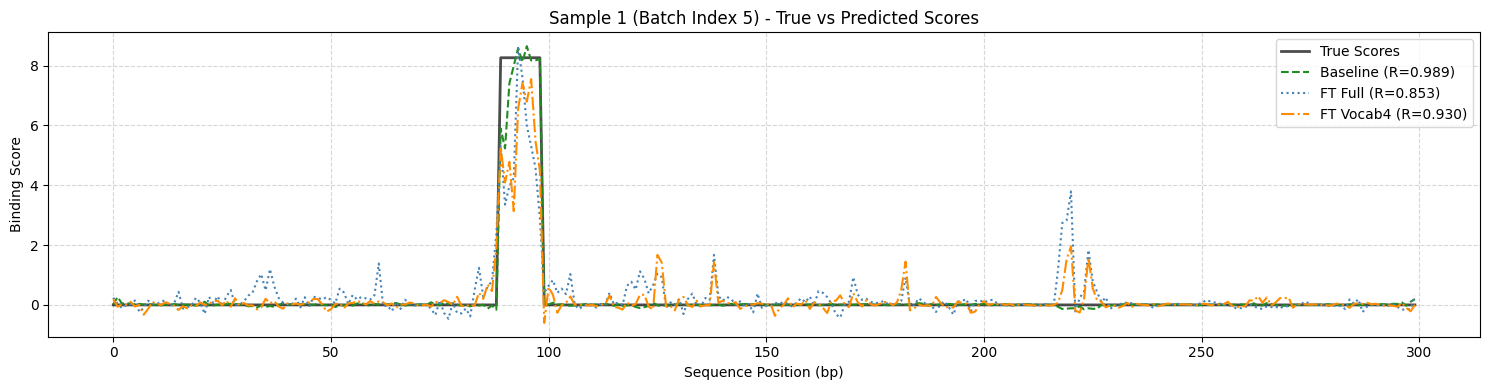

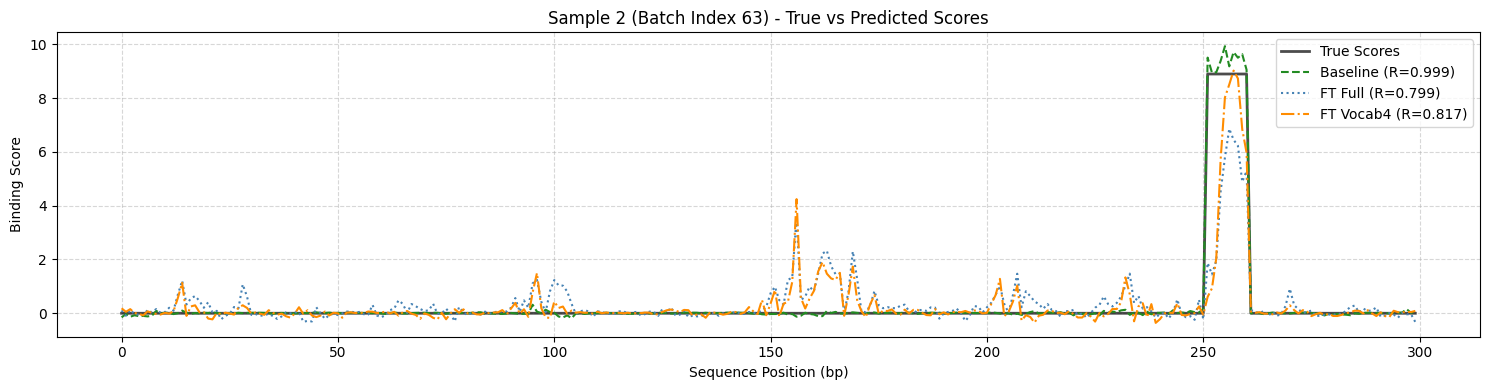

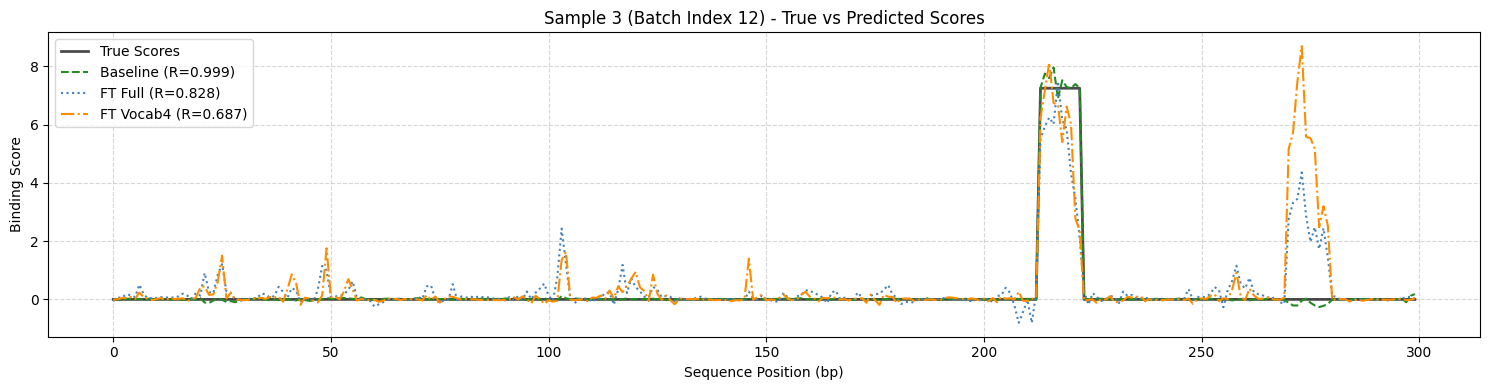

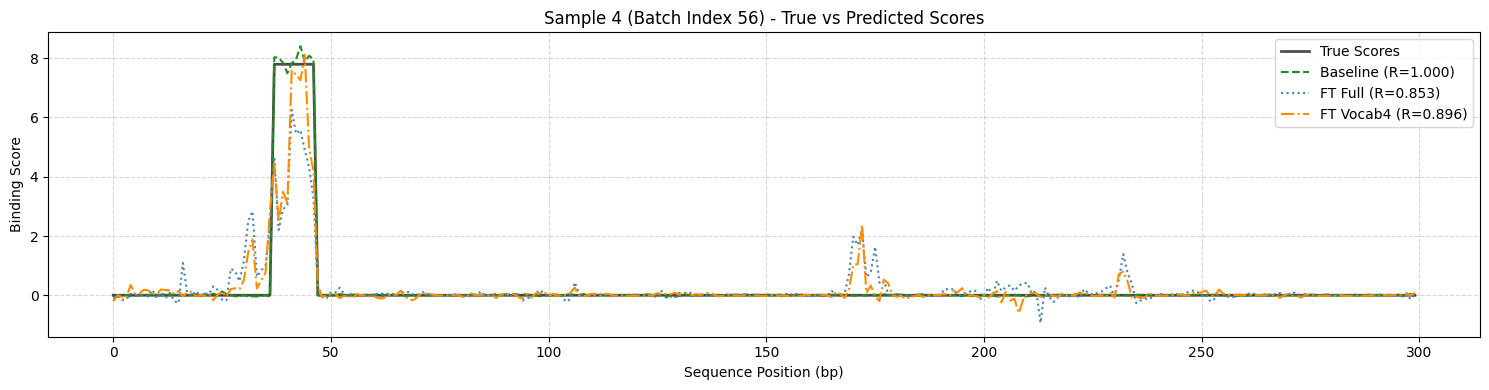

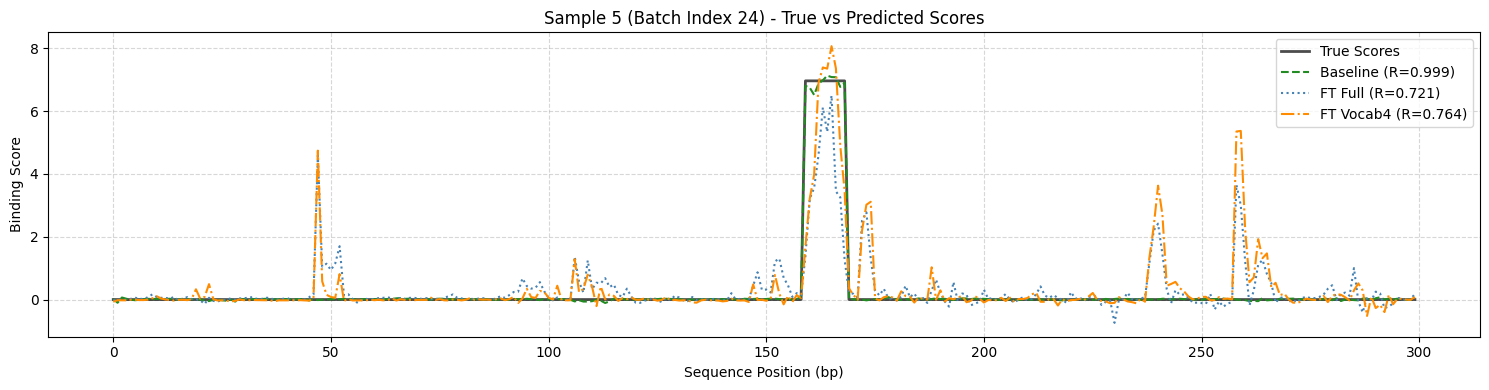

In [21]:
if batch_scores is not None and (preds_baseline is not None or preds_ft_full is not None or preds_ft_vocab4 is not None):
    print(f"\n Visualizing Predictions for {NUM_VIS_SAMPLES} Random Samples ")
    num_samples_in_batch = len(batch_scores)
    if num_samples_in_batch > 0:
        # Ensure we don't request more samples than available
        k = min(NUM_VIS_SAMPLES, num_samples_in_batch)
        random_indices = random.sample(range(num_samples_in_batch), k)

        for i, idx in enumerate(random_indices):
            true_scores = batch_scores[idx].cpu().numpy()
            seq_len = len(true_scores)
            x_axis = np.arange(seq_len)

            plt.figure(figsize=(15, 4))
            plt.plot(x_axis, true_scores, label='True Scores', color='black', linewidth=2, alpha=0.7)

            if preds_baseline is not None:
                pred_b = preds_baseline[idx].cpu().numpy()
                plt.plot(x_axis, pred_b, label=f'Baseline (R={pearson(preds_baseline[idx:idx+1], batch_scores[idx:idx+1]):.3f})', color='forestgreen', linestyle='--')

            if preds_ft_full is not None:
                pred_f = preds_ft_full[idx].cpu().numpy()
                plt.plot(x_axis, pred_f, label=f'FT Full (R={pearson(preds_ft_full[idx:idx+1], batch_scores[idx:idx+1]):.3f})', color='steelblue', linestyle=':')

            if preds_ft_vocab4 is not None:
                pred_v4 = preds_ft_vocab4[idx].cpu().numpy()
                plt.plot(x_axis, pred_v4, label=f'FT Vocab4 (R={pearson(preds_ft_vocab4[idx:idx+1], batch_scores[idx:idx+1]):.3f})', color='darkorange', linestyle='-.')

            plt.title(f"Sample {i+1} (Batch Index {idx}) - True vs Predicted Scores")
            plt.xlabel("Sequence Position (bp)")
            plt.ylabel("Binding Score")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()
    else:
        print("No samples in the batch to visualize.")
else:
    print("Skipping visualization, no batch data or predictions available.")